In [1]:
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install wget
!pip install pillow

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=ea43c71453bd9f84459ee844052ef968ce9160824692af91ea617dc868fa6916
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 13 18:14:05 2020

@author: matthew
"""



#%%
import scipy.interpolate
def matrix_show(matrix, title='', ax = None, fig = None, db = False):
    """Visualise a matrix
    Inputs:
        matrix | r2 array or masked array
        title | string
        ax | matplotlib axes
        db | boolean | bug fix for Spyder debugging.  If True, will allow figure to show when
                        debugging

    2017/10/18 | update so can be passed an axes and plotted in an existing figure
    2017/11/13 | fix bug in how colorbars are plotted.
    2017/12/01 | fix bug if fig is not None
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        fig, ax = plt.subplots()
    matrix = np.atleast_2d(matrix)                   # make at least 2d so can plot column/row vectors

    if isinstance(matrix[0,0], np.bool_):           # boolean arrays will plot, but mess up the colourbar
        matrix = matrix.astype(int)                 # so convert

    matrixPlt = ax.imshow(matrix,interpolation='none', aspect='auto')
    fig.colorbar(matrixPlt,ax=ax)
    ax.set_title(title)
    if db:
        plt.pause(1)

#%%

def open_MEG_dem(filename, scene_centre):
    """ A fudge function to open a DEM and make it look
    like it was created by the old function "dem_wrapper".

    """
    #from auxiliary_functions import crop_matrix_with_ll
    import pickle
    import numpy as np

    pix_in_m = 92.6                                                                 # one pixel in the dem will be 92.6m long                                                                                   # pixels in m.  92.6m for a SRTM3 pixel on equator}         # where I keep SRTM tiles (the DEM)}
    ll_extent = [13, 16, 39, 42]                                                    # start lon end lon start lat end lat of the DEM

    with open(filename, 'rb') as f:                                        # open the dem I (MEG) made
        dem = pickle.load(f)                                                # read the file, it's a masked array, hence _ma

    x_pixs = (ll_extent[1] - ll_extent[0])*1200                                                                             # coordinated of points in matrix form (ie 00 is top left)
    y_pixs = (ll_extent[3] - ll_extent[2])*1200
    X, Y = np.meshgrid(np.arange(0, x_pixs, 1), np.arange(0,y_pixs, 1))
    ij = np.vstack((np.ravel(X)[np.newaxis], np.ravel(Y)[np.newaxis]))                                          # pairs of coordinates of everywhere we have data
    ijk = np.vstack((ij, np.zeros((1,len(X)**2))))                                                                   #xy and 0 depth
    ijk_m = pix_in_m  * ijk


    dem_crop, _ = crop_matrix_with_ll(dem, (ll_extent[2], ll_extent[0]), 1200, scene_centre[0], scene_centre[1])

    return dem, dem_crop, ijk_m, ll_extent

#%%

def signal_atmosphere_topo(dem_m, strength_mean = 56.0, strength_var = 2.0, difference = False):
    """ Given a dem, return a topographically correlated APS, either for a single acquistion
    or for an interferometric pair.
    Inputs:
        dem_m | r4 ma | rank4 masked array, with water masked. Units = metres!
        strength_mean | float | rad/km of delay.  default is 56.0, taken from Fig5 Pinel 2011 (Statovolcanoes...)
        strength_var  | float | variance of rad/km delay.  Default is 2.0, which gives values similar to Fig 5 of above.
        difference | boolean | if False, returns for one acquisitin.  If true, returns for an interferometric pair (ie difference of two acquisitions)

    Outputs:
        ph_topo | r4 ma | topo correlated delay in m.  UNITS ARE M

    2019/09/11 | MEG | written.
    """
    import numpy as np
    import numpy.ma as ma

    envisat_lambda = 0.056                       #envisat/S1 wavelength in m
    dem = 0.001 * dem_m                        # convert from metres to km

    if difference is False:
        ph_topo = (strength_mean + strength_var * np.random.randn(1)) * dem
    elif difference is True:
        ph_topo_aq1 = (strength_mean + strength_var * np.random.randn(1)) * dem                         # this is the delay for one acquisition
        ph_topo_aq2 = (strength_mean + strength_var * np.random.randn(1)) * dem                         # and for another
        ph_topo = ph_topo_aq1 - ph_topo_aq2                                                             # interferogram is the difference, still in rad



    else:
        print("'difference' must be either True or False.  Exiting...")
        import sys; sys.exit()

    # convert from rad to m
    ph_topo_m = (ph_topo / (4*np.pi)) * envisat_lambda                               # delay/elevation ratio is taken from a paper (pinel 2011) using Envisat data


    if np.max(ph_topo_m) < 0:                                                       # ensure that it always start from 0, either increasing or decreasing
        ph_topo_m -= np.max(ph_topo_m)
    else:
        ph_topo_m -= np.min(ph_topo_m)

    ph_topo_m = ma.array(ph_topo_m, mask = ma.getmask(dem_m))

    return ph_topo_m



#%%

def signal_deformation(dem, water_mask, mogi_cent, source_cent, ijk_m, ll_extent, pix_in_m=92.6, heading=192, incidence=32):
    """ A function to make deformation from a mogi source and crop to size
    """
    import numpy as np
    import numpy.ma as ma

    def Mogi(m,xloc,nu,mu):
        """
        %
        %Computes displacements, strains and stresses from a point (Mogi) source.
        %Inputs m and xloc can be matrices; for multiple models, the deformation
        %fields from each are summed.
        %
        %Inputs:
        %    m = 4xn volume source geometry (length; length; length; length^3)
        %        (x-coord, y-coord, depth(+), volume change)
        % xloc = 3xs matrix of observation coordinates (length)
        %   nu = Poisson's ratio
        %   mu = shear modulus (if omitted, default value is unity)
        %
        %Outputs:
        %    U = 3xs matrix of displacements (length)
        %        (Ux,Uy,Uz)
        %    D = 9xn matrix of displacement derivatives
        %        (Dxx,Dxy,Dxz,Dyx,Dyy,Dyz,Dzx,Dzy,Dzz)
        %    S = 6xn matrix of stresses
        %        (Sxx,Sxy,Sxz,Syy,Syz,Szz)
        %
        %June 17, 1998. Peter Cervelli.
        %Revised November 3, 2000.
        %Fixed a bug ('*' multiplication should have been '.*'), August 22, 2001. Kaj Johnson
        %
        %For information on the basis for this code see:
        %
        %Okada, Y. Internal deformation due to shear and tensile faults in a half-space,
        %    Bull. Seismol. Soc. Am., 82, 1018-1049, 1992.

        2017/??/?? | Converted from Matlab to Python - derivates and stresses not converted.

        """

        import scipy.io
        import numpy as np

        _, n_data = xloc.shape
        _, models = m.shape
        Lambda=2*mu*nu/(1-2*nu)
        U=np.zeros((3,n_data))                        # set up the array to store displacements

        for i in range(models):                         # loop through each of the defo sources, I think?
            C=m[3]/(4*np.pi)
            x=xloc[0,:]-float(m[0,i])                          # difference in distance from centre of source (x)
            y=xloc[1,:]-float(m[1,i])                         # difference in distance from centre of source (y)
            z=xloc[2,:]
            d1=m[2,i]-z
            d2=m[2,i]+z
            R12=x**2+y**2+d1**2
            R22=x**2+y**2+d2**2
            R13=R12**1.5
            R23=R22**1.5
            R15=R12**2.5
            R25=R22**2.5
            R17=R12**3.5
            R27=R12**3.5

            #Calculate displacements
            U[0,:] = U[0,:] + C*( (3 - 4*nu)*x/R13 + x/R23 + 6*d1*x*z/R15 )
            U[1,:] = U[1,:] + C*( (3 - 4*nu)*y/R13 + y/R23 + 6*d1*y*z/R15 )
            U[2,:] = U[2,:] + C*( (3 - 4*nu)*d1/R13 + d2/R23 - 2*(3*d1**2 - R12)*z/R15)
        return U


    mogi_loc_pix = ll2xy((ll_extent[2], ll_extent[0]), 1200, np.array([[mogi_cent[0][0], mogi_cent[0][1]]]))            #centre
    mogi_loc_pix[0,1] = np.size(dem, axis=0) - mogi_loc_pix[0,1]                                                                # convert xy in matrix stlye  (ie from the top left, and not bottom left)
    mogi_loc_m = pix_in_m * mogi_loc_pix                                                                                            # convert to m
    mogi_cent.append(np.array([[mogi_loc_m[0,0], mogi_loc_m[0,1], mogi_cent[1], mogi_cent[2]]]).T)              # (xloc (m), yloc(m), depth (m), volume change (m^3)
    U_mogi = Mogi(mogi_cent[3],ijk_m,0.25,30e9)                                                                   # 3d displacement
    look = np.array([[np.sin(heading)*np.sin(incidence)],
                      [np.cos(heading)*np.sin(incidence)],
                      [np.cos(incidence)]])                                                                     # ground to satelite unit vector
    U_mogi_los = look.T @ U_mogi                                                                                # 3d displacement converted to LOS displacement

    x_pixs = (ll_extent[1] - ll_extent[0])*1200                     # coordinated of points in matrix form (ie 00 is top left)
    y_pixs = (ll_extent[3] - ll_extent[2])*1200

    defo_signal = np.reshape(U_mogi_los, (x_pixs, y_pixs))                                                        # column vector to rank 2 array



    defo_signal_crop, crop_ll_ur = crop_matrix_with_ll(defo_signal, (ll_extent[2], ll_extent[0]),
                                                       1200, source_cent[0], source_cent[1])

    defo_signal_crop = ma.array(defo_signal_crop, mask = water_mask)

    return defo_signal, defo_signal_crop


#%%

def signal_atmosphere_turb(n_atms, water_mask, n_pixs, Lc = None, difference = False, verbose = False,
                    interpolate_threshold = 100, mean_cm = 2):
    """ A function to create synthetic turbulent atmospheres based on the
    methods in Lohman Simmonds (sic?) 2005.  Note that due to memory issues,
    largers ones are made by interpolateing smaller ones.  Can return atmsopheres
    for an individual acquisition, or as the difference of two (as per an
    interferogram).

    Inputs:
        n_atms | int | number of atmospheres to generate
        n_pixs | int | side length (squares) for atmospheres in pixels
        Lc     | int | length scale, default is random and different for each one
        interpolate_threshold | int | if n_pixs is greater than this, images will be generated at size interpolate_threshold
                                        and then interpolate to the larger size.  This is as the distance matrix (which is
                                        of size n_pixs**2 x n_pixs**2 can get huge)
        max_cm | float | maximum strength of atmosphere, in cm.  Strength is chosen from a uniform distribution.

    Outputs:
        ph_turb | r3 array | n_atms x n_pixs x n_pixs, UNITS ARE M
        Lc      | r1 array | length scales used for each atmosphere

    2019/09/13 | MEG | adapted extensively from a simple script
    """

    import numpy as np
    import numpy.ma as ma
    from scipy.spatial import distance
    import scipy

    def generate_correlated_noise(pixel_distances, Lc, n_pixs_generate):
        """ given a matrix of pixel distances and a length scale for the noise,
        generate some 2d noise.
        """

        Cd = np.exp((-1 * pixel_distances)/(Lc))                                     # from the matrix of distances, convert to covariances using exponential equation
        Cd_L = np.linalg.cholesky(Cd)                                               # ie Cd = CD_L @ CD_L.T
        x = np.random.randn(n_pixs_generate**2)                               # Parsons 2007 syntax - x for uncorrelated noise
        y = Cd_L @ x                                                            # y for correlated noise
        y_2d = np.reshape(y, (n_pixs_generate,n_pixs_generate))                 # turn back to rank 2

        return y_2d

    def rescale_atmosphere(atm, mean_cm):
        """ a function to rescale a 2d atmosphere with any scale to a mean centered
        one with a min and max value drawn from a normal distribution.
        """
        atm -= np.mean(atm)
        if np.abs(np.min(atm)) > np.abs(np.max(atm)):                               # if range of negative numbers is larger
            atm *= ((np.random.randn(1) + mean_cm) / np.abs(np.min(atm)))             # strength is random up to max of max_cm drawn from uniform distribution
        else:
            atm *= ((np.random.randn(1) + mean_cm)/ np.max(atm))

        return atm

    #1: determine if linear interpolate is required
    if n_pixs > interpolate_threshold:
        if verbose:
            print(f"'n_pixs' is larger than 'interpolate_threshold' so images will be created "
                  f"at a size of {interpolate_threshold} and interpolated to a size of {n_pixs}.  ")
        n_pixs_generate = interpolate_threshold                                         # images will be generated at size n_pixs_generate
        interpolate = True
    else:
        n_pixs_generate = n_pixs
        interpolate = False

    #1a: make an array of the lenghth scales for each atmosphere
    if Lc is None:
        Lc = 10**(0.5 + 3*np.random.rand(n_atms))                                  # so Lc is in range 10^2 to 10^5
    else:
        Lc = np.repeat(Lc, n_atms)                                              # or if a single value is given, repeat so similar to above

    #2: calculate distance function between points
    ph_turb = np.zeros((n_atms, n_pixs_generate,n_pixs_generate))                                  # initiate output
    X, Y = np.meshgrid(np.arange(0,n_pixs_generate), np.arange(0,n_pixs_generate))                    # top left is (0,0)
    xy = np.hstack((np.ravel(X)[:,np.newaxis], np.ravel(Y)[:,np.newaxis]))      # convert into piels x 2 column vector
    pixel_distances = distance.cdist(xy,xy, 'euclidean')                        # calcaulte all pixelwise pairs - slow as (pixels x pixels)

    #3: generate atmospheres
    if difference is False:
        for i in range(n_atms):
            ph_turb[i,:,:] = generate_correlated_noise(pixel_distances, Lc[i], n_pixs_generate)
            if verbose:
                print(f'Generated {i} of {n_atms} single acquisition atmospheres.  ')
    elif difference is True:
        for i in range(n_atms):
            y_2d_1 = generate_correlated_noise(pixel_distances, Lc[i], n_pixs_generate)
            y_2d_2 = generate_correlated_noise(pixel_distances, Lc[np.random.randint(0, Lc.shape[0])], n_pixs_generate)         # pick anotehr length scale at random
            ph_turb[i,:,:] = y_2d_1 - y_2d_2                                        # difference between the two atmospheres
            if verbose:
                print(f'Generated {i} of {n_atms} interferogram atmospheres.  ')
    else:
        print("'difference' must be either True or False.  Quitting.  ")
        import sys; sys.exit()


    #4: possibly interplate to bigger size
    if interpolate:
        if verbose:
            print('Interpolating to the larger size...', end = '')
        ph_turb_output = np.zeros((n_atms, n_pixs,n_pixs))                                  # initiate output
        for atm_n, atm in enumerate(ph_turb):
            f = scipy.interpolate.interp2d(np.arange(0,n_pixs_generate), np.arange(0,n_pixs_generate), atm, kind='linear')
            ph_turb_output[atm_n,:,:] = f(np.linspace(0, n_pixs_generate, n_pixs), np.linspace(0, n_pixs_generate, n_pixs))
        if verbose:
            print('Done!')

    else:
        ph_turb_output = ph_turb

    #5: rescale to correct range (i.e. a couple of cm)
    ph_turb_cm = np.zeros(ph_turb_output.shape)
    for atm_n, atm in enumerate(ph_turb_output):
        ph_turb_cm[atm_n,] = rescale_atmosphere(atm, mean_cm)

    ph_turb_output *= 0.01                                                      # convert from cm to m


    water_mask_r3 = ma.repeat(water_mask[np.newaxis,], ph_turb_output.shape[0], axis = 0)
    ph_turb_output_ma = ma.array(ph_turb_output, mask = water_mask_r3)

    return ph_turb_output_ma, Lc


#%% other less exciting functions

def crop_matrix_with_ll(im, im_ll, pixs2deg, centre, square):
    """
    A script to crop an image (stored as an array) to have side length 'square' (in km)
    , with 'centre' in the middle.
    Input:
        im | array | the gridded image as a an array
        im_ll | tuple | lat lon of bottom left corner of im
        pixs2deg | int  | number of pixels in im that are 1deg long
        centre | tuple | lat lon of centre of crop
        square | int | lenght (in km) of side of crop

    Output:
        im_crop | array | cropped image
        [ll, ur] | list of tuples | lat lon of lower left and upper right corner of crop.

    Dependencies:
        ll2xy

    2017/03/01 | return the lower left and upper right corner of the cropped dem
    2017/03/02 | fix a bug that caused the area returned by the ll of the corners was twice as long in each dimension as it should be

    """

    import numpy as np
    km_per_deg = 110.9
    pixs2km = pixs2deg/km_per_deg                                                # take 1 deg at 110.9 km - compromise between lat (110.6) and lon (111.3)
    y_pixs, x_pixs = im.shape                                   # get size of image that we're going to crop

    summit_xy = ll2xy(im_ll, pixs2deg, np.array([[centre[0], centre[1]]]))                    #xy from bottom left corner
    summit_xy[0,1] = y_pixs - summit_xy[0,1]                                                    # xy from top left (ie more matrix like notation, but still xy and not yx)

    x_low = summit_xy[0,0] - pixs2km*(square/2.0)              # get the max/min coords for that distance from point of interest
    if x_low < 0:                                               # check that not falling outside dem that we have
        x_low = 0
    x_high = summit_xy[0,0] + pixs2km*(square/2.0)
    if x_high > x_pixs:                                         # as above
        x_high = x_pixs
    y_low = summit_xy[0,1] - pixs2km*(square/2.0)
    if y_low < 0:                                               # as above
        y_low = 0
    y_high = summit_xy[0,1] + pixs2km*(square/2.0)
    if y_high > y_pixs:                                         # as above
        y_high = y_pixs

    im_crop = im[int(y_low):int(y_high), int(x_low):int(x_high)]                    # do the cropping

    ll_lowleft = (centre[0] - (square/2.0)/km_per_deg, centre[1] - (square/2.0)/km_per_deg)
    ll_upright = (centre[0] + (square/2.0)/km_per_deg, centre[1] + (square/2.0)/km_per_deg)

    return im_crop, [ll_lowleft, ll_upright]






def ll2xy(bottom_left, pix2deg, points):
    """
    Input:
        bottom_left | 1x2 np.array (lat lon) |lat long of bottom left pixel of xy space
        deg2pix | 1 |number of pixels in 1 deg (e.g. 1200 for SRTM3)
        points  | nx2   np.array (lat lon)| n >= 1 for it to work (ie no 1d arrays, must be at least 1x2)
    Output:
        points_xy | nx2 | (x y) in pixels from lower left corner as intergers
                                Careful, as matrix indices are from top left forner

    xy space has to be orientated so that north is vertical (ie angles are not supported)

    2016/12/14 | written
    @author: Matthew Gaddes
    """
    import numpy as np

    n_data, dims = points.shape
    points_diff = points - bottom_left              # difference in degrees from bottom left
    points_diff_pix = points_diff * pix2deg
    points_xy = np.roll(points_diff_pix, 1, 1)          # lat lon is yx, switch to xy
    points_xy = points_xy.astype(int)                   # pixels must be integers
    return points_xy

def col_to_ma(col, pixel_mask):
    """ A function to take a column vector and a 2d pixel mask and reshape the column into a masked array.
    Useful when converting between vectors used by BSS methods results that are to be plotted

    Inputs:
        col | rank 1 array |
        pixel_mask | array mask (rank 2)

    Outputs:
        source | rank 2 masked array | colun as a masked 2d array

    2017/10/04 | collected from various functions and placed here.

    """
    import numpy.ma as ma
    import numpy as np

    source = ma.array(np.zeros(pixel_mask.shape), mask = pixel_mask )
    source.unshare_mask()
    source[~source.mask] = col.ravel()
    return source


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  1 10:14:02 2019

@author: mgaddes
"""

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pickle
import sys
import os.path
from os import path

# from auxiliary_functions import matrix_show                                   # good for quick plots to look at matrices
# from auxiliary_functions import open_MEG_dem                                  # this will open the digital elevation model of central Italy
# from auxiliary_functions import signal_deformation                            # this will generate deformation
# from auxiliary_functions import signal_atmosphere_turb                        # and the turbulent atmospheric signal (APS, spatially correlated noise, like a cloudy sky)
# from auxiliary_functions import signal_atmosphere_topo                        # and the topographically corrleated atmospheric signal (APS)
# from auxiliary_functions import col_to_ma


#%% ################################ Things to set ################################

## Campi Flegrei
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
deformation_centre = [(40.84, 14.14), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal

try :
    n_interferograms = int(input("Generate how many inputs? : "))
except Exception as e:
    print("Not an integer")
    sys.exit(1)

output_path = os.getcwd()
output_path = f"{output_path}/output"
print("Starting...")


#%%  Load a DEM for Italy that is stored locally (no downloading tiles etc.  )
def quick_dem_plot(dem, title):
    """ Plot dems quickly
    """
    fig1, ax = plt.subplots()                                                       # make a figure to show it
    fig1.canvas.set_window_title(title)
    fig1.suptitle(title)
    matrixPlt = ax.imshow(dem, vmin = 0, vmax = np.max(dem))                                              # best to set lower limit to 0 as voids are filled with -32768 so mess the colours up
    fig1.colorbar(matrixPlt,ax=ax)

dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)

water_mask = ma.getmask(dem_crop)                                                      # DEM has no values for water, and we have no radar return from water, so good to keep a mask available

# lets look at the big DEM (the file I sent)
quick_dem_plot(dem, "A digital elevation model (DEM) of Italy, white is water, heights are in metres")

# lets look at the small dem
quick_dem_plot(dem_crop, "cropped to area of interest")

# lets change "scene_centre" to look somewhere else
scene_centre = [(40.82, 14.43), 20]                     # lat lon scene width(km), note small change to lat and lon
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "cropped to area of interest for new location (Vesuvius")

# Or we can change "scene_centre" to be a bigger scene
scene_centre = [(40.82, 14.43), 40]                     # lat lon scene width(km), note change to 40
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "cropped to area of interest for new location (Vesuvius), 40km scene")

# and reset it
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "back to the original, 40km scene")

#%% Second, make a deformation signal

signals_m = {}                                                                              # these should be in metres

_, signals_m["deformation"] = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
matrix_show(signals_m["deformation"], title = "Deformaiton signal")

# we can offset of the deformaiton signal (ie set a new lat lon)
deformation_centre = [(40.83, 14.12), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal
_, signals_m["deformation"] = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
matrix_show(signals_m["deformation"], title = "Deformaiton signal - shifted")



#%% make a topograhically correlated atmospheric phase screen (APS), using the DEM

signals_m['topo_correlated_APS'] = signal_atmosphere_topo(dem_crop, strength_mean = 56.0, strength_var = 12.0, difference = True)                    # dem must be in metres

matrix_show(signals_m["topo_correlated_APS"], title = "Topographically correlated APS")

#%% make a turbulent APS (just spatially correlated noise)

ph_turb, _ = signal_atmosphere_turb(1, water_mask, dem_crop.shape[0], Lc = None, verbose=True, interpolate_threshold = 100, mean_cm = 2)
signals_m["turbulent_APS"] = ph_turb[0,]

matrix_show(signals_m["turbulent_APS"], title = "Turbulent APS - just spatially correlated noise")
del ph_turb

#%% Combine all the signals to make an interferogram

signals_m["combined"] = ma.zeros((dem_crop.shape))

for key in signals_m.keys():
     signals_m["combined"] += signals_m[key]



# with a figure output

fig1, axes = plt.subplots(1,4)

for plot_n, key in enumerate(signals_m.keys()):
    matrix_show(signals_m[key], ax = axes[plot_n], fig = fig1, title = key)
    axes[plot_n].set_aspect('equal')



fig1.suptitle('Signals (in metres).  Note that if the turbulent APS is strong, (ie the noise), it might dwarf the other signals')


#%% Lets make a time series

# things to set
#n_interferograms = 5                                    # these will be this many interferograms in our time series
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
deformation_centre = [(40.84, 14.14), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal


dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
water_mask = ma.getmask(dem_crop)
_, deformation_m = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
topo_correlated_APS_m = signal_atmosphere_topo(dem_crop, strength_mean = 56.0, strength_var = 12.0, difference = True)                    # dem must be in metres
S = np.vstack((ma.compressed(deformation_m), ma.compressed(topo_correlated_APS_m)))                                # signals will be stored as row vectors

ph_turb_m, _ = signal_atmosphere_turb(n_interferograms, water_mask, dem_crop.shape[0], Lc = None, verbose=True, interpolate_threshold = 100, mean_cm = 2)
N = np.zeros((n_interferograms, S.shape[1]))
for row_n, ph_turb in enumerate(ph_turb_m):
    N[row_n,] = ma.compressed(ph_turb)


A = np.random.randn(n_interferograms,2)                                             # these column vectors control the strength of each source through time

X = A@S + N                                                                         # do the mixing: X = AS + N

# The interferograms are now rows in X
# and we can convert them back to masked arrays using this little function ()
f, axes = plt.subplots(1, n_interferograms)
for counter, row in enumerate(X):
    ifg = col_to_ma(row, pixel_mask = water_mask)
    matrix_show(ifg, title = f"Interferogram {counter}", fig=f, ax = axes[counter])
    axes[counter].set_aspect('equal')


A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)
                                                                                # so we can make it stronger
X = A@S + N                                                                         # do the mixing: X = AS + N
f, axes = plt.subplots(1, n_interferograms)
output_path = "/content/drive/My Drive/Simulator/out"
for counter, row in enumerate(X):
    ifg = col_to_ma(row, pixel_mask = water_mask)
    matrix_show(ifg, title = f"Interferogram {counter}", fig=f, ax = axes[counter])
    axes[counter].set_aspect('equal')
    #plt.imsave(f"/home/csunix/sc16a2b/Project/Simulator/output/Interferogram{counter}.jpg",ifg)
    #picture at the bottom part
    plt.imsave(f"{output_path}/Interferogram{counter}.jpg",ifg)

# so now the deformation signal should be a bit clearer in the time series.


Generate how many inputs? : 5
Starting...
'n_pixs' is larger than 'interpolate_threshold' so images will be created at a size of 100 and interpolated to a size of 217.  
Generated 0 of 1 single acquisition atmospheres.  
Interpolating to the larger size...Done!
'n_pixs' is larger than 'interpolate_threshold' so images will be created at a size of 100 and interpolated to a size of 217.  
Generated 0 of 5 single acquisition atmospheres.  
Generated 1 of 5 single acquisition atmospheres.  
Generated 2 of 5 single acquisition atmospheres.  
Generated 3 of 5 single acquisition atmospheres.  
Generated 4 of 5 single acquisition atmospheres.  
Interpolating to the larger size...Done!


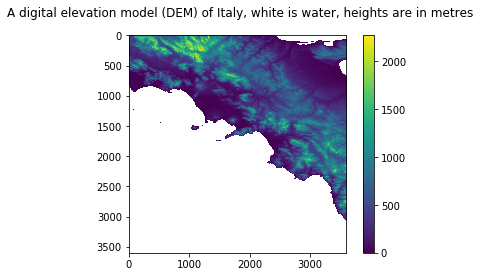

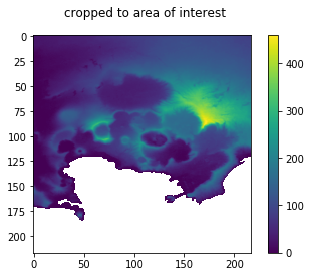

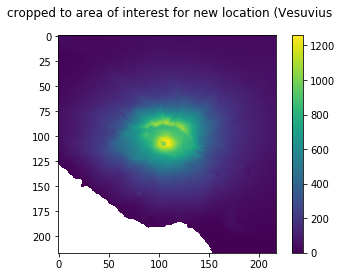

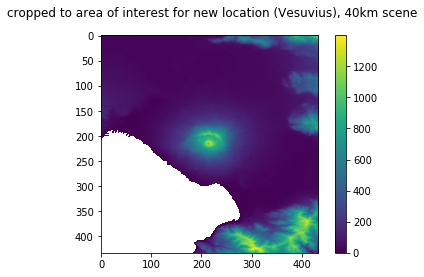

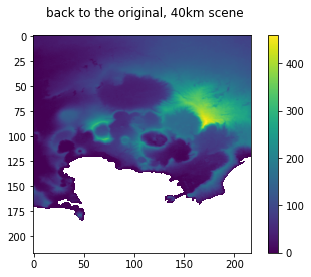

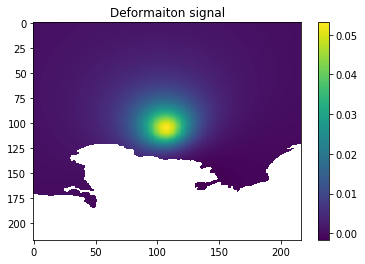

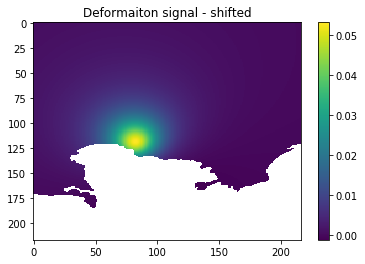

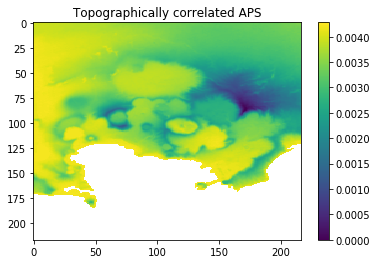

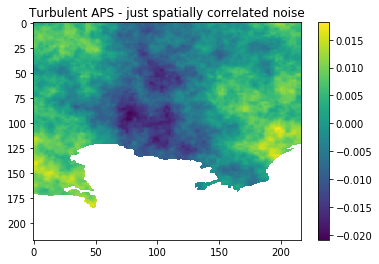

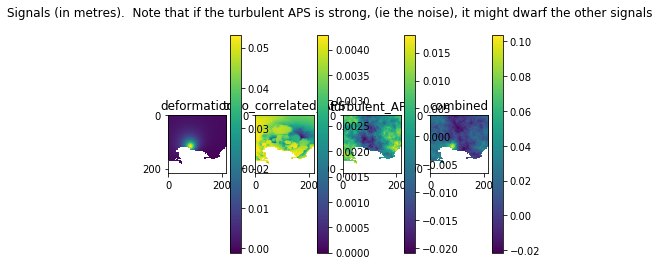

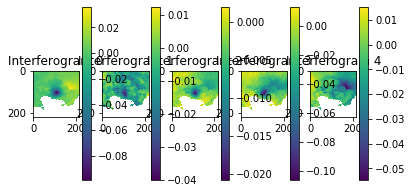

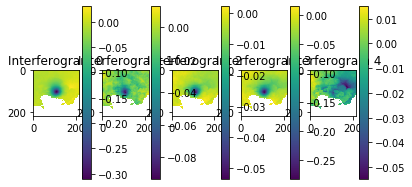

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  1 10:14:02 2019

@author: mgaddes
"""

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pickle
import sys
import os.path
from os import path

# from auxiliary_functions import matrix_show                                   # good for quick plots to look at matrices
# from auxiliary_functions import open_MEG_dem                                  # this will open the digital elevation model of central Italy
# from auxiliary_functions import signal_deformation                            # this will generate deformation
# from auxiliary_functions import signal_atmosphere_turb                        # and the turbulent atmospheric signal (APS, spatially correlated noise, like a cloudy sky)
# from auxiliary_functions import signal_atmosphere_topo                        # and the topographically corrleated atmospheric signal (APS)
# from auxiliary_functions import col_to_ma


#%% ################################ Things to set ################################

## Campi Flegrei
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
deformation_centre = [(40.84, 14.14), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal

try :
    n_interferograms = int(input("Generate how many inputs? : "))
except Exception as e:
    print("Not an integer")
    sys.exit(1)

output_path = os.getcwd()
output_path = f"{output_path}/output"
print("Starting...")


#%%  Load a DEM for Italy that is stored locally (no downloading tiles etc.  )
def quick_dem_plot(dem, title):
    """ Plot dems quickly
    """
    fig1, ax = plt.subplots()                                                       # make a figure to show it
    fig1.canvas.set_window_title(title)
    fig1.suptitle(title)
    matrixPlt = ax.imshow(dem, vmin = 0, vmax = np.max(dem))                                              # best to set lower limit to 0 as voids are filled with -32768 so mess the colours up
    fig1.colorbar(matrixPlt,ax=ax)

dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)

water_mask = ma.getmask(dem_crop)                                                      # DEM has no values for water, and we have no radar return from water, so good to keep a mask available

# lets look at the big DEM (the file I sent)
quick_dem_plot(dem, "A digital elevation model (DEM) of Italy, white is water, heights are in metres")

# lets look at the small dem
quick_dem_plot(dem_crop, "cropped to area of interest")

# lets change "scene_centre" to look somewhere else
scene_centre = [(40.82, 14.43), 20]                     # lat lon scene width(km), note small change to lat and lon
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "cropped to area of interest for new location (Vesuvius")

# Or we can change "scene_centre" to be a bigger scene
scene_centre = [(40.82, 14.43), 40]                     # lat lon scene width(km), note change to 40
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "cropped to area of interest for new location (Vesuvius), 40km scene")

# and reset it
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "back to the original, 40km scene")

#%% Second, make a deformation signal

signals_m = {}                                                                              # these should be in metres

_, signals_m["deformation"] = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
matrix_show(signals_m["deformation"], title = "Deformaiton signal")

# we can offset of the deformaiton signal (ie set a new lat lon)
deformation_centre = [(40.83, 14.12), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal
_, signals_m["deformation"] = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
matrix_show(signals_m["deformation"], title = "Deformaiton signal - shifted")



#%% make a topograhically correlated atmospheric phase screen (APS), using the DEM

signals_m['topo_correlated_APS'] = signal_atmosphere_topo(dem_crop, strength_mean = 56.0, strength_var = 12.0, difference = True)                    # dem must be in metres

matrix_show(signals_m["topo_correlated_APS"], title = "Topographically correlated APS")

#%% make a turbulent APS (just spatially correlated noise)

ph_turb, _ = signal_atmosphere_turb(1, water_mask, dem_crop.shape[0], Lc = None, verbose=True, interpolate_threshold = 100, mean_cm = 2)
signals_m["turbulent_APS"] = ph_turb[0,]

matrix_show(signals_m["turbulent_APS"], title = "Turbulent APS - just spatially correlated noise")
del ph_turb

#%% Combine all the signals to make an interferogram

signals_m["combined"] = ma.zeros((dem_crop.shape))

for key in signals_m.keys():
     signals_m["combined"] += signals_m[key]



# with a figure output

fig1, axes = plt.subplots(1,4)

for plot_n, key in enumerate(signals_m.keys()):
    matrix_show(signals_m[key], ax = axes[plot_n], fig = fig1, title = key)
    axes[plot_n].set_aspect('equal')



fig1.suptitle('Signals (in metres).  Note that if the turbulent APS is strong, (ie the noise), it might dwarf the other signals')


#%% Lets make a time series

# things to set
#n_interferograms = 5                                    # these will be this many interferograms in our time series
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
deformation_centre = [(40.84, 14.14), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal


dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
water_mask = ma.getmask(dem_crop)
_, deformation_m = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
topo_correlated_APS_m = signal_atmosphere_topo(dem_crop, strength_mean = 56.0, strength_var = 12.0, difference = True)                    # dem must be in metres
S = np.vstack((ma.compressed(deformation_m), ma.compressed(topo_correlated_APS_m)))                                # signals will be stored as row vectors

ph_turb_m, _ = signal_atmosphere_turb(n_interferograms, water_mask, dem_crop.shape[0], Lc = None, verbose=True, interpolate_threshold = 100, mean_cm = 2)
N = np.zeros((n_interferograms, S.shape[1]))
for row_n, ph_turb in enumerate(ph_turb_m):
    N[row_n,] = ma.compressed(ph_turb)


A = np.random.randn(n_interferograms,2)                                             # these column vectors control the strength of each source through time

X = A@S + N                                                                         # do the mixing: X = AS + N

# The interferograms are now rows in X
# and we can convert them back to masked arrays using this little function ()
f, axes = plt.subplots(1, n_interferograms)
for counter, row in enumerate(X):
    ifg = col_to_ma(row, pixel_mask = water_mask)
    matrix_show(ifg, title = f"Interferogram {counter}", fig=f, ax = axes[counter])
    axes[counter].set_aspect('equal')

# for i in range(10):
#   A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)
#                                                                                   # so we can make it stronger
#   X = A@S + N                                                                         # do the mixing: X = AS + N
#   f, axes = plt.subplots(1, n_interferograms)
#   output_path = "/content/drive/My Drive/Simulator/output"
#   row = X[0]
#   ifg = col_to_ma(row, pixel_mask = water_mask)
#   matrix_show(ifg, title = f"Interferogram {i}", fig=f, ax = axes[0])
#   axes[0].set_aspect('equal')

#   X[0] = row


A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)
                                                                                # so we can make it stronger
X = A@S + N                                                                         # do the mixing: X = AS + N
f, axes = plt.subplots(1, n_interferograms)
output_path = "/content/drive/My Drive/Simulator/out"
for counter, row in enumerate(X):
    ifg = col_to_ma(row, pixel_mask = water_mask)
    matrix_show(ifg, title = f"Interferogram {counter}", fig=f, ax = axes[counter])
    axes[counter].set_aspect('equal')
    #plt.imsave(f"/home/csunix/sc16a2b/Project/Simulator/output/Interferogram{counter}.jpg",ifg)
    #picture at the bottom part
    plt.imsave(f"{output_path}/Interferogram{counter}.jpg",ifg)

# so now the deformation signal should be a bit clearer in the time series.




# so now the deformation signal should be a bit clearer in the time series.
##THIS IS FOR TESTING ONLY

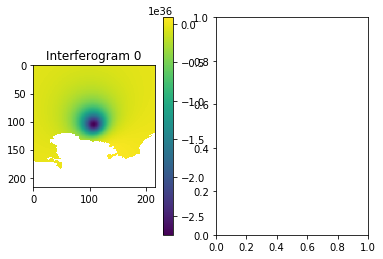

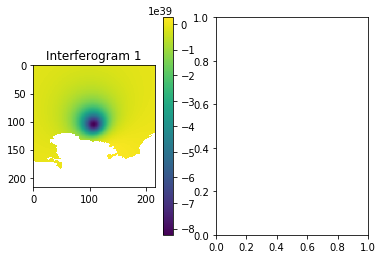

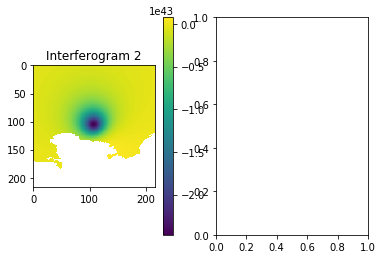

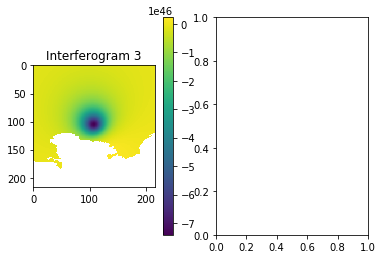

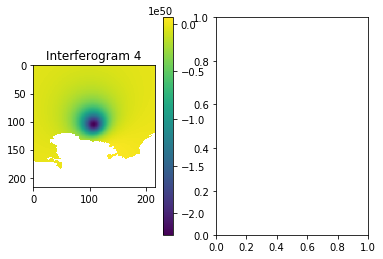

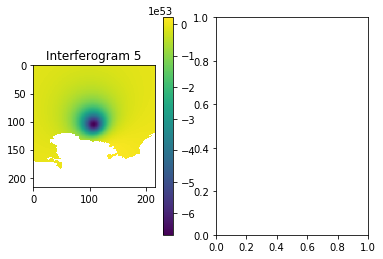

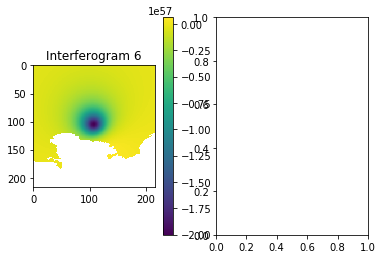

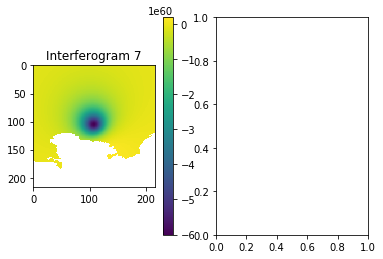

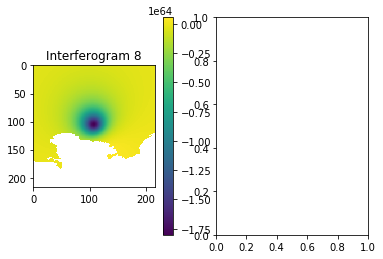

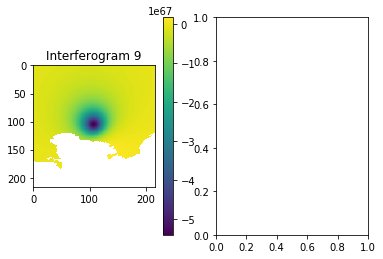

In [0]:
A_copy = A
for i in range(10):
  A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)                                                                             # so we can make it stronger
  X = A@S + N                                                                         # do the mixing: X = AS + N
  f, axes = plt.subplots(1, n_interferograms)
  output_path = "/content/drive/My Drive/Simulator/output"
  row = X[0]
  ifg = col_to_ma(row, pixel_mask = water_mask)
  matrix_show(ifg, title = f"Interferogram {i}", fig=f, ax = axes[0])
  axes[0].set_aspect('equal')

  X[0] = row
  A = A_copy

Generate how many inputs? : 2
Starting...
'n_pixs' is larger than 'interpolate_threshold' so images will be created at a size of 100 and interpolated to a size of 217.  
Generated 0 of 1 single acquisition atmospheres.  
Interpolating to the larger size...Done!
'n_pixs' is larger than 'interpolate_threshold' so images will be created at a size of 100 and interpolated to a size of 217.  
Generated 0 of 2 single acquisition atmospheres.  
Generated 1 of 2 single acquisition atmospheres.  
Interpolating to the larger size...Done!


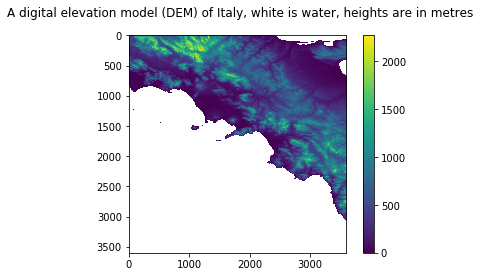

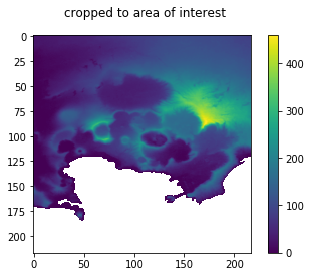

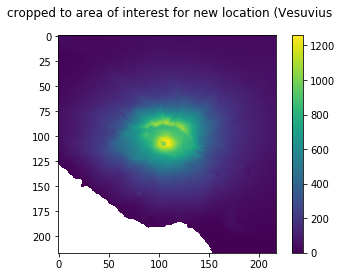

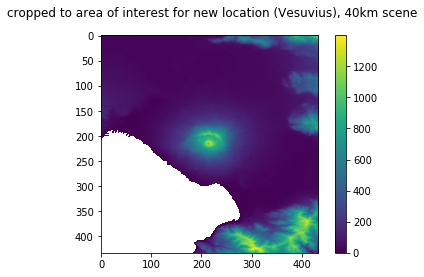

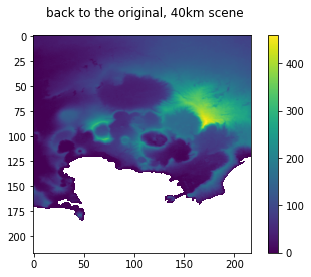

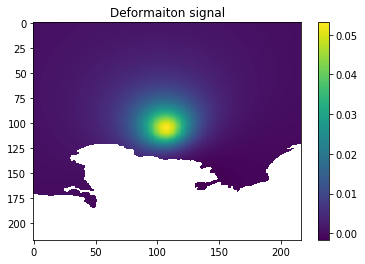

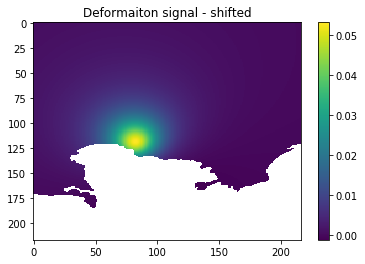

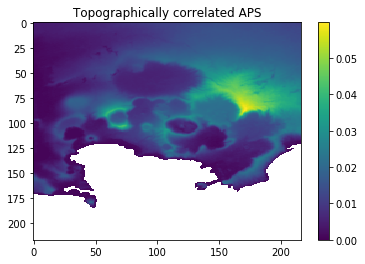

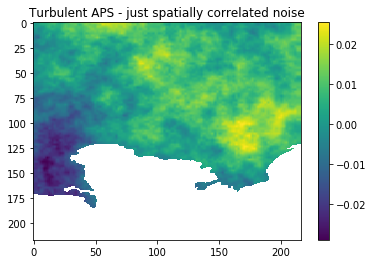

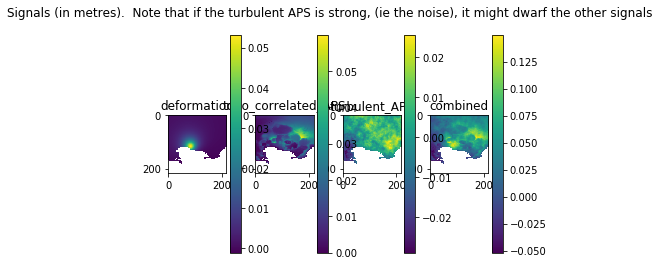

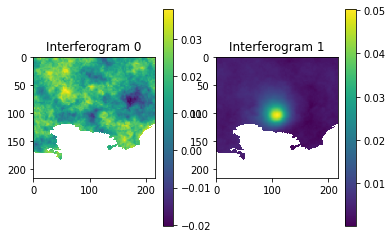

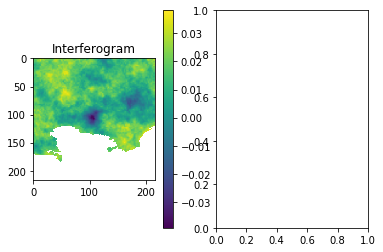

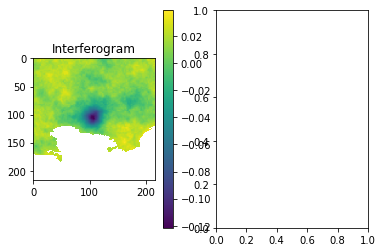

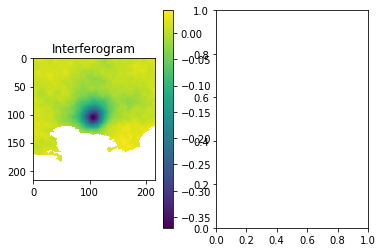

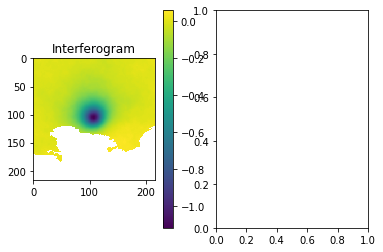

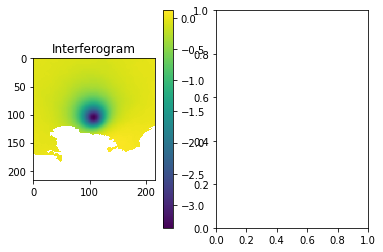

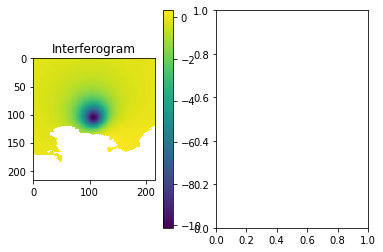

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  1 10:14:02 2019

@author: mgaddes
"""

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pickle
import sys
import os.path
from os import path

# from auxiliary_functions import matrix_show                                   # good for quick plots to look at matrices
# from auxiliary_functions import open_MEG_dem                                  # this will open the digital elevation model of central Italy
# from auxiliary_functions import signal_deformation                            # this will generate deformation
# from auxiliary_functions import signal_atmosphere_turb                        # and the turbulent atmospheric signal (APS, spatially correlated noise, like a cloudy sky)
# from auxiliary_functions import signal_atmosphere_topo                        # and the topographically corrleated atmospheric signal (APS)
# from auxiliary_functions import col_to_ma


#%% ################################ Things to set ################################

## Campi Flegrei
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
deformation_centre = [(40.84, 14.14), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal

try :
    n_interferograms = int(input("Generate how many inputs? : "))
except Exception as e:
    print("Not an integer")
    sys.exit(1)

output_path = os.getcwd()
output_path = f"{output_path}/output"
print("Starting...")


#%%  Load a DEM for Italy that is stored locally (no downloading tiles etc.  )
def quick_dem_plot(dem, title):
    """ Plot dems quickly
    """
    fig1, ax = plt.subplots()                                                       # make a figure to show it
    fig1.canvas.set_window_title(title)
    fig1.suptitle(title)
    matrixPlt = ax.imshow(dem, vmin = 0, vmax = np.max(dem))                                              # best to set lower limit to 0 as voids are filled with -32768 so mess the colours up
    fig1.colorbar(matrixPlt,ax=ax)

dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)

water_mask = ma.getmask(dem_crop)                                                      # DEM has no values for water, and we have no radar return from water, so good to keep a mask available

# lets look at the big DEM (the file I sent)
quick_dem_plot(dem, "A digital elevation model (DEM) of Italy, white is water, heights are in metres")

# lets look at the small dem
quick_dem_plot(dem_crop, "cropped to area of interest")

# lets change "scene_centre" to look somewhere else
scene_centre = [(40.82, 14.43), 20]                     # lat lon scene width(km), note small change to lat and lon
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "cropped to area of interest for new location (Vesuvius")

# Or we can change "scene_centre" to be a bigger scene
scene_centre = [(40.82, 14.43), 40]                     # lat lon scene width(km), note change to 40
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "cropped to area of interest for new location (Vesuvius), 40km scene")

# and reset it
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
quick_dem_plot(dem_crop, "back to the original, 40km scene")

#%% Second, make a deformation signal

signals_m = {}                                                                              # these should be in metres

_, signals_m["deformation"] = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
matrix_show(signals_m["deformation"], title = "Deformaiton signal")

# we can offset of the deformaiton signal (ie set a new lat lon)
deformation_centre = [(40.83, 14.12), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal
_, signals_m["deformation"] = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
matrix_show(signals_m["deformation"], title = "Deformaiton signal - shifted")



#%% make a topograhically correlated atmospheric phase screen (APS), using the DEM

signals_m['topo_correlated_APS'] = signal_atmosphere_topo(dem_crop, strength_mean = 56.0, strength_var = 12.0, difference = True)                    # dem must be in metres

matrix_show(signals_m["topo_correlated_APS"], title = "Topographically correlated APS")

#%% make a turbulent APS (just spatially correlated noise)

ph_turb, _ = signal_atmosphere_turb(1, water_mask, dem_crop.shape[0], Lc = None, verbose=True, interpolate_threshold = 100, mean_cm = 2)
signals_m["turbulent_APS"] = ph_turb[0,]

matrix_show(signals_m["turbulent_APS"], title = "Turbulent APS - just spatially correlated noise")
del ph_turb

#%% Combine all the signals to make an interferogram

signals_m["combined"] = ma.zeros((dem_crop.shape))

for key in signals_m.keys():
     signals_m["combined"] += signals_m[key]



# with a figure output

fig1, axes = plt.subplots(1,4)

for plot_n, key in enumerate(signals_m.keys()):
    matrix_show(signals_m[key], ax = axes[plot_n], fig = fig1, title = key)
    axes[plot_n].set_aspect('equal')



fig1.suptitle('Signals (in metres).  Note that if the turbulent APS is strong, (ie the noise), it might dwarf the other signals')


#%% Lets make a time series

# things to set
#n_interferograms = 5                                    # these will be this many interferograms in our time series
scene_centre = [(40.84, 14.14), 20]                     # lat lon scene width(km)
deformation_centre = [(40.84, 14.14), 2000 , 1e6]        # lat lon depth(m) volume change(m) of hte deformation signal


dem, dem_crop, ijk_m, ll_extent = open_MEG_dem("/content/drive/My Drive/Simulator/italian_dem.pkl", scene_centre)
water_mask = ma.getmask(dem_crop)
_, deformation_m = signal_deformation(dem, water_mask, deformation_centre, scene_centre, ijk_m, ll_extent)
topo_correlated_APS_m = signal_atmosphere_topo(dem_crop, strength_mean = 56.0, strength_var = 12.0, difference = True)                    # dem must be in metres
S = np.vstack((ma.compressed(deformation_m), ma.compressed(topo_correlated_APS_m)))                                # signals will be stored as row vectors

ph_turb_m, _ = signal_atmosphere_turb(n_interferograms, water_mask, dem_crop.shape[0], Lc = None, verbose=True, interpolate_threshold = 100, mean_cm = 2)
N = np.zeros((n_interferograms, S.shape[1]))
for row_n, ph_turb in enumerate(ph_turb_m):
    N[row_n,] = ma.compressed(ph_turb)


A = np.random.randn(n_interferograms,2)                                             # these column vectors control the strength of each source through time

X = A@S + N                                                                         # do the mixing: X = AS + N

# The interferograms are now rows in X
# and we can convert them back to masked arrays using this little function ()
f, axes = plt.subplots(1, n_interferograms)
for counter, row in enumerate(X):
    ifg = col_to_ma(row, pixel_mask = water_mask)
    matrix_show(ifg, title = f"Interferogram {counter}", fig=f, ax = axes[counter])
    axes[counter].set_aspect('equal')


A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)                                                                               # so we can make it stronger
X = A@S + N                                                                         # do the mixing: X = AS + N
f, axes = plt.subplots(1, n_interferograms)
output_path = "/content/drive/My Drive/Simulator/output"
row = X[0]
ifg = col_to_ma(row, pixel_mask = water_mask)
matrix_show(ifg, title = f"Interferogram", fig=f, ax = axes[0])
axes[0].set_aspect('equal')
X[0] = row

A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)                                                                               # so we can make it stronger
X = A@S + N                                                                         # do the mixing: X = AS + N
f, axes = plt.subplots(1, n_interferograms)
output_path = "/content/drive/My Drive/Simulator/output"
row = X[0]
ifg = col_to_ma(row, pixel_mask = water_mask)
matrix_show(ifg, title = f"Interferogram", fig=f, ax = axes[0])
axes[0].set_aspect('equal')
X[0] = row

A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)                                                                               # so we can make it stronger
X = A@S + N                                                                         # do the mixing: X = AS + N
f, axes = plt.subplots(1, n_interferograms)
output_path = "/content/drive/My Drive/Simulator/output"
row = X[0]
ifg = col_to_ma(row, pixel_mask = water_mask)
matrix_show(ifg, title = f"Interferogram", fig=f, ax = axes[0])
axes[0].set_aspect('equal')
X[0] = row

A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)                                                                               # so we can make it stronger
X = A@S + N                                                                         # do the mixing: X = AS + N
f, axes = plt.subplots(1, n_interferograms)
output_path = "/content/drive/My Drive/Simulator/output"
row = X[0]
ifg = col_to_ma(row, pixel_mask = water_mask)
matrix_show(ifg, title = f"Interferogram", fig=f, ax = axes[0])
axes[0].set_aspect('equal')
X[0] = row


A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)                                                                               # so we can make it stronger
X = A@S + N                                                                         # do the mixing: X = AS + N
f, axes = plt.subplots(1, n_interferograms)
output_path = "/content/drive/My Drive/Simulator/output"
row = X[0]
ifg = col_to_ma(row, pixel_mask = water_mask)
matrix_show(ifg, title = f"Interferogram", fig=f, ax = axes[0])
axes[0].set_aspect('equal')
X[0] = row

A[:,0] *= 3                                                                     # first column controls the strength of the deforamation source (A@S, and deformation is first row in S)                                                                               # so we can make it stronger
X = A@S + N                                                                         # do the mixing: X = AS + N
f, axes = plt.subplots(1, n_interferograms)
output_path = "/content/drive/My Drive/Simulator/output"
row = X[0]
ifg = col_to_ma(row, pixel_mask = water_mask)
matrix_show(ifg, title = f"Interferogram", fig=f, ax = axes[0])
axes[0].set_aspect('equal')
X[0] = row



    

# so now the deformation signal should be a bit clearer in the time series.
###USE THE ABOVE CELL, THIS IS FOR TESTING